# Life Cycle Assessment - PBLCA


## Load modules

First, the user has to load the framework and generate a process.

In [1]:
%matplotlib widget
import pandas as pd
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_top_down_interp,
    models_energy_with_fuel_effect,
    models_offset,
    models_climate_fair,
    models_energy_cost_complex,
    models_operation_cost_top_down,
    models_abatements_cost_simplified,
)
from aeromaps.models.impacts.life_cycle_assessment.life_cycle_assessment import LifeCycleAssessment
import brightway2 as bw
import lca_algebraic as agb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import collections
import time

plt.style.use("bmh")

In [2]:
models = {
    "models_traffic": models_traffic,
    "models_efficiency_top_down_interp": models_efficiency_top_down_interp,
    "models_energy_with_fuel_effect": models_energy_with_fuel_effect,
    "models_offset": models_offset,
    "models_climate_fair": models_climate_fair,
    "life_cycle_assessment": LifeCycleAssessment(
        name="life_cycle_assessment",
        configuration_file="./data/lca_data/configuration_file_lca_tsas.yaml",
        split_by="phase",
    ),
}

Initial setup of EcoInvent already done, skipping. To reset the project use option `reset_project=True` in configuration file.
Creating custom LCIA method  ('PBLCIA', 'climate change', 'climate change radiative forcing')


Writing activities to SQLite3 database:
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/17/2025 22:33:28
  Finished: 09/17/2025 22:33:28
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.26
Added 1 new biosphere flows
1 methods
1 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 1 characterization factors
Creating custom LCIA method  ('PBLCIA', 'biosphere integrity', 'biosphere integrity')
1 methods
39 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 39 characterization factors
Creating custom LCIA method  ('PBLCIA', 'biogeochemical', 'nitrogen cycle')
1 methods
2 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 2 characterization factors
Creating custom LCIA method  ('PBLCIA', 'biogeochemical', 'phosphorus cycle')
1 methods
2 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 2 characterization factors
Creating custom LCIA method  ('PBLCIA', 'freshwater change', 'freshwater use')
1 methods
15 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 15 characterization factors
Creating custom LCIA method  ('PBLCIA', 'stratospheric oz

Writing activities to SQLite3 database:
0% [################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/17/2025 22:33:34
  Finished: 09/17/2025 22:33:34
  Total time elapsed: 00:00:00
  CPU %: 166.20
  Memory %: 1.26
Added 15 new biosphere flows
1 methods
75 cfs
0 unlinked cfs
Wrote 1 LCIA methods with 75 characterization factors
Building LCA model from configuration file
LCA model successfully created
Parametrizing LCIA impacts... Done.


In [3]:
list(bw.databases)

['biosphere3',
 'ecoinvent-3.10-cutoff',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2020',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2030',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2040',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2050',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2060',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2070',
 'biosphere_user',
 'Foreground DB']

## Scenario 1

### a) Set parameters

In [4]:
# Create process from scenario (previously calculated)
process = create_process(
    configuration_file="data/config_files/config_is2medium.json",
    models=models,
)

### b) Compute

In [5]:
start_time = time.time()
process.compute()
process.write_json()
print("--- %s seconds ---" % (time.time() - start_time))

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

--- 19.99800682067871 seconds ---


### c) Results and plots

In [6]:
process_data_vector_outputs_scenario_1 = process.data["vector_outputs"]
process_data_float_inputs_scenario_1 = process.data["float_inputs"]
process_data_climate_scenario_1 = process.data["climate_outputs"]
lca_outputs_scenario_1 = process.data["lca_outputs"]
#lca_outputs_scenario_1

In [14]:
def plot_stacked_evolution_subplots(xarray_data, scaling_factors=None, label_y="Impact"):
    """
    scaling_factors : list | float | None
        - list : liste de coefficients dans l'ordre des `methods`
        - float : coefficient global
        - None : équivalent à 1
    label_y : str
        - Label commun à l'axe Y de tous les sous-graphiques
    """

    df = xarray_data.to_dataframe().reset_index()
    df = df.set_index(["impacts", "axis", "year"])
    df = df.pivot_table(values="lca", index=["impacts", "axis"], columns="year")

    # Filtrer
    df_filtered = df[~df.index.get_level_values("axis").str.contains("sum")]
    df_filtered = df_filtered[
        ~df_filtered.index.get_level_values("axis").str.contains("_other_")
    ]

    methods = df_filtered.index.get_level_values("impacts").unique()
    years = df_filtered.columns

    # 🔑 On enlève la dernière méthode
    methods = methods[:-1]

    n_methods = len(methods)
    n_cols = 3
    n_rows = math.ceil(n_methods / n_cols)

    palette = sns.color_palette("Set2", len(df_filtered.index.levels[1]))
    palette_dict = {
        "aircraft_production": (palette[3], ""),
        "airport": (palette[1], ""),
        "kerosene_production": (palette[2], ""),
        "biofuel_production": (palette[5], ""),
        "e_fuel_production": (palette[8], ""),
        "hydrogen_production": (palette[6], ""),
        "CO2 from combustion": (palette[7], ""),
        "Non-CO2 from combustion": ("0.8", "//"),
    }

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=False
    )
    axes = axes.flatten()

    for i, method in enumerate(methods):
        df_method = df_filtered.xs(method, level="impacts")
        df_method.index = df_method.index.str.replace("_other_", "Others")

        # Regroupements
        co2_rows = df_method.index.str.startswith("CO2")
        if co2_rows.any():
            co2_aggregated = df_method[co2_rows].sum()
            co2_aggregated.name = "CO2 from combustion"
            df_method = pd.concat([df_method[~co2_rows], co2_aggregated.to_frame().T])

        nonco2_rows = df_method.index.str.startswith("non_CO2")
        if nonco2_rows.any():
            nonco2_aggregated = df_method[nonco2_rows].sum()
            nonco2_aggregated.name = "Non-CO2 from combustion"
            df_method = pd.concat([df_method[~nonco2_rows], nonco2_aggregated.to_frame().T])

        df_method = df_method.loc[~(df_method.eq(0).all(axis=1))]

        # 🔑 Facteur d’échelle depuis liste, scalaire ou None
        if scaling_factors is None:
            factor = 1.0
        elif isinstance(scaling_factors, (list, tuple)):
            factor = scaling_factors[i]
        else:  # scalaire global
            factor = scaling_factors

        # Appliquer facteur + multiplication par 100
        df_method = (df_method / factor) * 100

        # Tracé
        colors = [palette_dict[key][0] for key in df_method.index]
        stacks = axes[i].stackplot(
            years,
            df_method,
            labels=df_method.index,
            alpha=0.8,
            colors=colors,
            linewidth=0.2,
        )

        # Nom du subplot
        name = method[2]
        name = name.replace("(with non-CO2)", "").replace("total", "").split("- ")[0]
        name = name.replace(":", "\n")
        name = "".join([a if a.isupper() else b for a, b in zip(name, name.title())])
        
        if i == 0:  
            name = f"Biogeochemical flows\n{name}"
        if i == 1:  
            name = f"Biogeochemical flows\n{name}"
        if i == 2:  
            name = f"{name}\nLand use + Radiative Forcing*"
        if i == 3:
            name = f"Climate change\nRadiative forcing*"
        
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel(label_y)  # label commun
        axes[i].grid(True)
        axes[i].set_axisbelow(True)
        axes[i].ticklabel_format(axis="y", scilimits=(0, 4))
        axes[i].set_facecolor("white")
        
          # Set hatches pattern
        hatches = [palette_dict[key][1] for key in df_method.index]
        for stack, hatch, values in zip(stacks, hatches, df_method.values):
            if np.any(values != 0):  # Check if the layer has non-zero values
                stack.set_edgecolor("0.1")
            # stack.set_edgecolor(color)
            if hatch:
                stack.set_hatch(hatch)

    # Légende commune
    all_handles, all_labels = [], []
    for ax in axes[:n_methods]:  # on ignore axes vides si présents
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    entries = collections.OrderedDict()
    for handle, label in zip(all_handles, all_labels):
        if label == "Others":
            continue
        if label == "CO2 from combustion":
                label_name = label.replace("CO2 from combustion", r"CO$_2$ from combustion (and production if *)")
        elif "CO2" in label:
            label_name = label.replace("CO2", r"CO$_2$")
        elif "e_fuel" in label:
            label_name = label.replace("e_fuel", "E-Fuel").replace("_", " ").title()
        else:
            label_name = label.replace("_", " ").title()
        entries[label_name] = handle

    legend = fig.legend(
        entries.values(),
        entries.keys(),
        loc="lower center",
        bbox_to_anchor=(0.5, 0),
        ncol=4,
        fontsize=11,
        title="Contribution",
        title_fontsize=12,
    )

    bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(
        fig.transFigure.inverted()
    )
    fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

    plt.show()

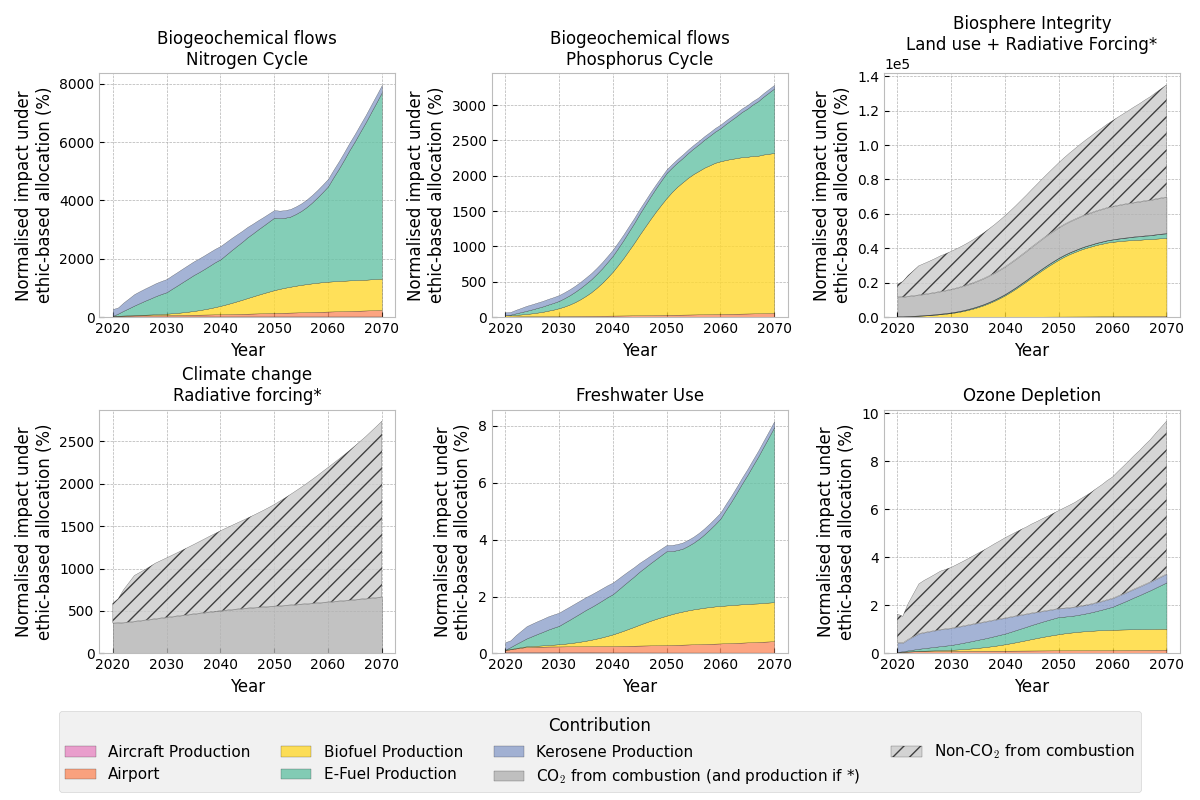

In [15]:
scales = [1.0e-2, 2.0e-4, 1.44e-3, 8.8e-3, 8.88e1, 6.0e-2, 1] 
plot_stacked_evolution_subplots(lca_outputs_scenario_1, scaling_factors=scales, label_y="Normalised impact under\nethic-based allocation (%)")
plt.savefig("ethic.pdf")

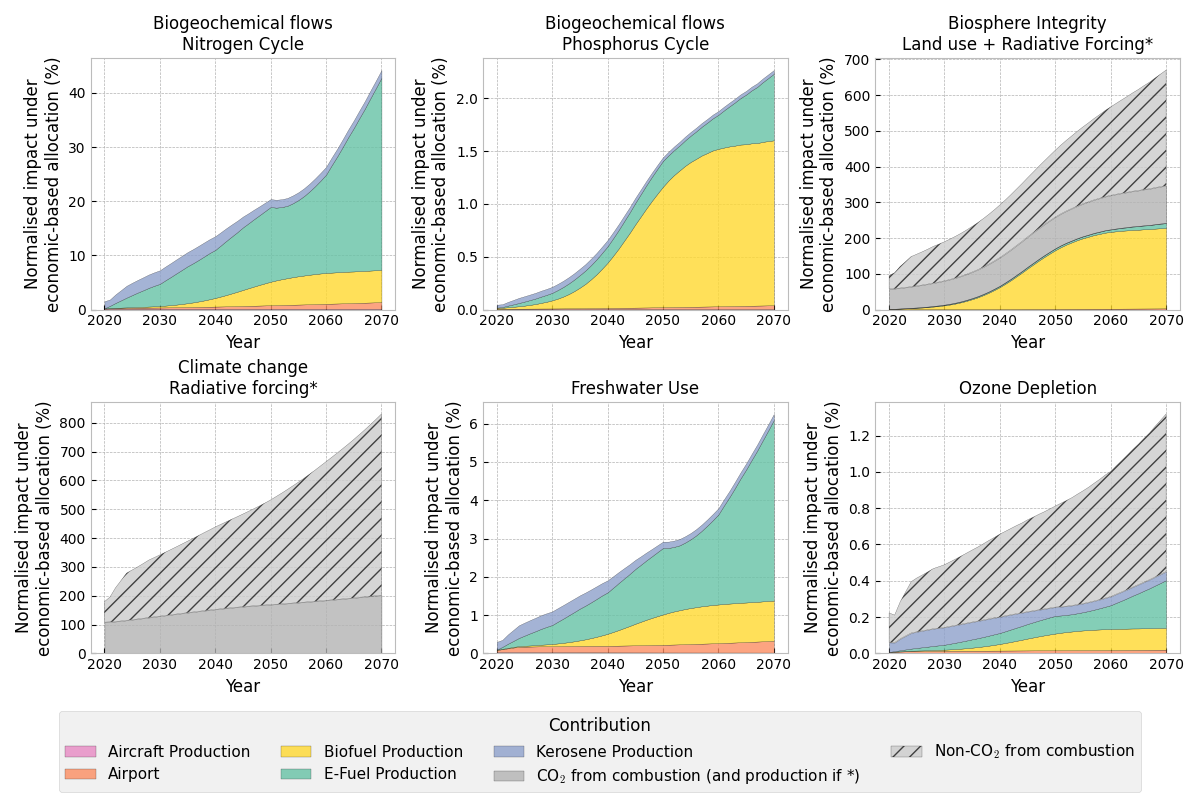

In [16]:
scales = [1.8, 2.9e-1, 2.9e-1, 2.9e-2, 1.16e2, 4.4e-1, 1]
plot_stacked_evolution_subplots(lca_outputs_scenario_1, scaling_factors=scales, label_y="Normalised impact under\neconomic-based allocation (%)")
plt.savefig("economic.pdf")